In [14]:
# import tqdm
# import torch as T
# import os

# pth = "./dataset_embeddings/convnextv2_atto.fcmae_ft_in1k"
# num_encoding_blocks = len(os.listdir(pth))

# embeddings = T.zeros(num_encoding_blocks * 250, 320, 7, 7)
# valid = T.zeros(num_encoding_blocks * 250, dtype=T.bool)

# print(f"number of encodings: {len(os.listdir(pth))}")
# for (i, f) in tqdm.tqdm(enumerate(os.listdir(pth)), total=num_encoding_blocks, desc="Loading encodings"):
#     ten = T.load(os.path.join(pth, f), map_location="cpu")
#     block_size = ten.size(0)
#     embeddings[(i * 250):(i * 250 + block_size), ...] = ten[:]
#     valid[(i * 250):(i * 250 + block_size)] = True

# T.save(embeddings, "./dataset_embeddings/convnextv2_atto.fcmae_ft_in1k-embeddings.pt")
# T.save(valid,      "./dataset_embeddings/convnextv2_atto.fcmae_ft_in1k-valid.pt")

In [37]:
import torch as T
from motion_capture.model.modules import find_best_checkpoint_path, VisionModule
from motion_capture.data.datasets import COCO2017GlobalPersonInstanceSegmentation

person_instance_dataset = COCO2017GlobalPersonInstanceSegmentation(
    image_folder_path = "//192.168.2.206/data/datasets/COCO2017/images",
    annotation_folder_path = "//192.168.2.206/data/datasets/COCO2017/annotations",
    image_shape_WH=(224, 224),
    max_num_persons=1,
    max_segmentation_points=100
)

model = VisionModule.load_from_checkpoint(find_best_checkpoint_path("checkpoints/full-image-experiment/test-run"), map_location="cpu").eval()


found best model with loss: 0.04203116521239281 from C:\Users\noone\Documents\programming\motion-capture\checkpoints\full-image-experiment\test-run\epoch=2-step=306-val_loss=0.0420.ckpt


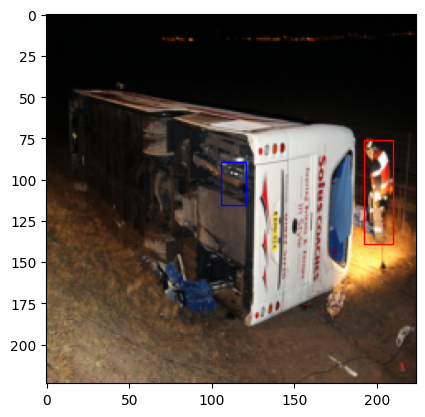

In [48]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


x, y = person_instance_dataset[3]

plt.imshow((x.permute(1, 2, 0) * 255).byte().numpy())

for bbox in y["bboxes"]:
    bbox = bbox * T.tensor([224] * 4)
    
    plt.gca().add_patch(
        Rectangle(
            (bbox[0], bbox[1]), 
            bbox[2] - bbox[0], 
            bbox[3] - bbox[1], 
            linewidth=1,
            edgecolor="r", 
            facecolor="none"))

y_ = model(x.unsqueeze(0))[0]

for bbox in y_:
    bbox = bbox * T.tensor([224] * 4)
    bbox = bbox.detach().numpy()
    
    plt.gca().add_patch(
        Rectangle(
            (bbox[0], bbox[1]), 
            bbox[2] - bbox[0], 
            bbox[3] - bbox[1], 
            linewidth=1,
            edgecolor="b", 
            facecolor="none"))



In [1]:
import torch as T
import timm
from motion_capture.core import benchmark

ghostnet = timm.create_model("timm/ghostnetv2_100.in1k", features_only=True)

benchmark.model_speedtest(ghostnet, (1, 3, 224, 224))
[a.shape for a in ghostnet(T.randn(1, 3, 224, 224))]

c:\Users\noone\Documents\programming\motion-capture\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


speedtest engaged for <class 'timm.models._features.FeatureListNet'>
	# parameters: 1.246948 M


KeyboardInterrupt: 

In [7]:
import torch as T
from motion_capture.model import modules

model = modules.VisionModule(
    backbone = "convnextv2_atto.fcmae_ft_in1k",
    head = {
        "input_dim": 320,
        "input_sequence_length": 49,
        
        "output_dim": 4,
        "output_sequence_length": 10,
        
        "depth": 5,
        "continuous_output": True,
    }
)

In [8]:
from motion_capture.core.benchmark import model_speedtest

model_speedtest(model, (1, 3, 224, 224))
model = model.to("cpu")

speedtest engaged for <class 'motion_capture.model.modules.VisionModule'>
	# parameters: 3.74268 M


speedtest: 100%|██████████| 1000/1000 [00:08<00:00, 120.94it/s]

	fps: 120.90498737220841


In [9]:
model.backbone = model.backbone.eval()
model.heads = model.heads.train()
model = model.to("cuda")

x, y = T.randn(1, 3, 224, 224).to("cuda"), T.randn(1, 10, 4).to("cuda")
opt = T.optim.SGD(model.heads.parameters(), lr=1e-3)


In [10]:
for i in range(1000):
    y_pred = model(x)["personBbox"]
    loss = T.nn.functional.mse_loss(y_pred, y)
    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    print(f"loss: {loss.item()}")
    

loss: 1.3749860525131226
loss: 1.3730440139770508
loss: 1.3708542585372925
loss: 1.3682247400283813
loss: 1.3648370504379272
loss: 1.3601421117782593
loss: 1.3532341718673706
loss: 1.3429816961288452
loss: 1.3293185234069824
loss: 1.3151813745498657
loss: 1.3039880990982056
loss: 1.295972228050232
loss: 1.2900131940841675
loss: 1.2852712869644165
loss: 1.281272292137146
loss: 1.2777514457702637
loss: 1.274553656578064
loss: 1.2715834379196167
loss: 1.2687782049179077
loss: 1.2660959959030151
loss: 1.2635071277618408
loss: 1.260991096496582
loss: 1.2585315704345703
loss: 1.2561168670654297
loss: 1.2537380456924438
loss: 1.2513874769210815
loss: 1.249060034751892
loss: 1.2467507123947144
loss: 1.2444559335708618
loss: 1.2421725988388062
loss: 1.2398979663848877
loss: 1.2376303672790527
loss: 1.2353676557540894
loss: 1.2331081628799438
loss: 1.2308508157730103
loss: 1.228594183921814
loss: 1.2263375520706177
loss: 1.224079966545105
loss: 1.2218207120895386
loss: 1.2195594310760498
loss: 1

In [ ]:
# import timm
# import torch as T
# import torch.nn as nn
# import pytorch_lightning as pl
# from motion_capture.model.models import VQVAE, VQVAEHead

# class VisionModel(pl.LightningModule):
    
#     def __init__(
#         self,
        
#         backbone: str,
#         vqvae: dict,
#         heads: dict,
        
#         # - training parameters
#         optimizer: T.optim.Optimizer = None,
#         optimizer_kwargs: dict = None,
#         lr_scheduler_warmup_epochs: int = None,
#         lr_scheduler: T.optim.lr_scheduler = None,
#         lr_scheduler_kwargs: dict = None
        
#         # - loss scale parameters
#         reconstruction_loss_scale: float = 1.0,
#         codebook_loss_scale: float = 1.0,
#         prediction_loss_scales: dict = None
#         ):
        
#         super().__init__()
#         self.save_hyperparameters()
        
#         self.backbone = timm.create_model(backbone, pretrained=False, features_only=True)
#         self.vqvae = vqvae = VQVAE(**vqvae)
        
#         self.heads = nn.ModuleDict({k: VQVAEHead(**v) for k, v in heads.items()})
        
#     def forward(self, x, skip_backbone=False):
        
#         if not skip_backbone:
#             backbone_out = self.backbone(x)[-1].flatten(2).permute(0, 2, 1)
#         else:
#             backbone_out = x
        
#         vqvae_out = self.vqvae(backbone_out)
        
#         heads_out = {}
#         for k in self.heads:
#             heads_out[k] = self.heads[k](vqvae_out["codebook_onehots"])
        
#         return {
#             "heads": heads_out, 
#             "vqvae": vqvae_out
#         }
    
#     def get_losses(self, 
#         heads_out, heads_targets,
#         vqvae_out, vqvae_target):
        
#         reconstruction_loss, codebook_loss = self.vqvae.compute_loss(vqvae_reconstruction_target, vqvae_out["reconstruction"], vqvae_out["z"], vqvae_out["codebook_indecies"])
#         prediction_losses = {
#             k: self.hparams.prediction_loss_scales.get(k, 1) * self.heads[k].compute_loss(heads_targets[k], heads_out[k]) 
#             for k in self.heads
#         }
        
#         return {
#             "vqvae-reconstruction": reconstruction_loss * self.hparams.reconstruction_loss_scale,
#             "vqvae-codebook": codebook_loss * self.hparams.codebook_loss_scale,
#             **prediction_losses
#         }
    
#     # def head_wise_step(self, batch, mode):
        
#     #     x, y = batch
#     #     outputs = self(x)
#     #     losses = {}
#     #     for k, head_output in outputs.items():
#     #         loss = self.compute_loss(head_output, y[k], self.hparams.heads[k]["loss_fn"])
#     #         losses[k] = loss
#     #         self.log(f"{mode}_loss_{k}", loss, on_step=True, on_epoch=False, prog_bar=True)
#     #     self.log(f"{mode}_loss", sum(losses.values()) / len(losses), on_step=False, on_epoch=True, prog_bar=True)
#     #     return losses
    
#     # def training_step(self, batch, batch_id):
#     #     return self.head_wise_step(batch, "train")
#     # def validation_step(self, batch, batch_idx):
#     #     self.log("lr", self.trainer.optimizers[0].param_groups[0]["lr"], on_step=False, on_epoch=True, prog_bar=False)
#     #     return self.head_wise_step(batch, "val")
#     # def test_step(self, batch, batch_idx):
#     #     return self.head_wise_step(batch, "test")
    
#     # def configure_optimizers(self):
        
#     #     assert self.hparams.optimizer, "optimizer not set for training"
        
#     #     opt = self.hparams.optimizer(self.parameters(), **self.hparams.optimizer_kwargs)
        
#     #     warmup_scheduler = T.optim.lr_scheduler.LinearLR(opt, start_factor=0.1, total_iters=self.hparams.lr_scheduler_warmup_epochs)
#     #     scheduler = self.hparams.lr_scheduler(opt, **self.hparams.lr_scheduler_kwargs)
#     #     lr_scheduler = T.optim.lr_scheduler.SequentialLR(opt, schedulers=[
#     #         warmup_scheduler, 
#     #         scheduler
#     #     ], milestones=[self.hparams.lr_scheduler_warmup_epochs])
        
#     #     return {
#     #         "optimizer": opt,
#     #         "lr_scheduler": lr_scheduler
#     #     }

In [ ]:
# model = VisionModel(
#     backbone = "timm/convnextv2_atto.fcmae_ft_in1k",
#     vqvae = {
#         "input_dim": 320,
#         "codebook_dim": 512,
#         "num_codebook_entries": 1024,
#         "output_dim": 320,
#         "codebook_sequence_length": 15,
#         "output_sequence_length": 49,
#         "transformer": {
#             "nhead": 2,
#             "num_encoder_layers": 1,
#             "num_decoder_layers": 1,
#             "dim_feedforward": 512,
#             "dropout": 0.1,
#             "activation": "gelu"
#         }
#     },
#     heads = {
#         "personBbox": {
#             "input_dim": 1024,
#             "output_dim": 4,
#             "latent_dim": 512,
#             "output_sequence_length": 10,
#             "output_type": "continuous",
#             "transformer": {
#                 "nhead": 2,
#                 "num_encoder_layers": 1,
#                 "num_decoder_layers": 1,
#                 "dim_feedforward": 512,
#                 "activation": "gelu"
#             }
#         }
#     }
    
# )

In [ ]:
# from motion_capture.core import benchmark

# benchmark.model_speedtest(model, (3, 3, 224, 224))


In [ ]:
student_net_dataset = []
teacher_net_dataset = []

from motion_capture.data.datasets import COCO2017GlobalPersonInstanceSegmentation
person_instance_dataset = COCO2017GlobalPersonInstanceSegmentation(
    image_folder_path = "//192.168.2.206/data/datasets/COCO2017/images",
    annotation_folder_path = "//192.168.2.206/data/datasets/COCO2017/annotations",
    image_shape_WH=(224, 224),
    max_num_persons=10,
    max_segmentation_points=100
)

## PyTorch Pretrained Models Speedtest

In [ ]:
from torchvision import models as torchModels
from motion_capture.model import models as mocapModels
import torch as T

In [ ]:
object_detection_models = {
    "fcos_resnet50_fpn": torchModels.detection.fcos_resnet50_fpn(weights=torchModels.detection.FCOS_ResNet50_FPN_Weights.COCO_V1),
    "fasterrcnn_mobilenet_v3_large_320_fpn": torchModels.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=torchModels.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1),
    "fasterrcnn_mobilenet_v3_large_fpn": torchModels.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=torchModels.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1),
    "fasterrcnn_resnet50_fpn_v2": torchModels.detection.fasterrcnn_resnet50_fpn_v2(weights=torchModels.detection.FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1),
    "fasterrcnn_resnet50_fpn": torchModels.detection.fasterrcnn_resnet50_fpn(weights=torchModels.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1),
    "retinanet_resnet50_fpn_v2": torchModels.detection.retinanet_resnet50_fpn_v2(weights=torchModels.detection.RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1),
    "retinanet_resnet50_fpn": torchModels.detection.retinanet_resnet50_fpn(weights=torchModels.detection.RetinaNet_ResNet50_FPN_Weights.COCO_V1),
    "ssd300_vgg16": torchModels.detection.ssd300_vgg16(weights=torchModels.detection.SSD300_VGG16_Weights.COCO_V1),
    "ssdlite320_mobilenet_v3_large": torchModels.detection.ssdlite320_mobilenet_v3_large(weights=torchModels.detection.SSDLite320_MobileNet_V3_Large_Weights.COCO_V1),
}